# Ensemble Methods

The goal of **ensemble methods** is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Two families of ensemble methods are usually distinguished:

In **averaging methods**, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

**Examples**: [Bagging methods](https://scikit-learn.org/stable/modules/ensemble.html#bagging), [Forests of randomized trees](https://scikit-learn.org/stable/modules/ensemble.html#forest), …

By contrast, in **boosting methods**, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

Examples: [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), [Gradient Tree Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting), …

## Bagging
The term bagging is short for “*Bootstrap Aggregating*”. A bootstrap is a sample of a dataset with replacement.

This means that a **new dataset** is created from a random sample of an existing dataset where a given row may be selected and added more than once to the sample (replacement).

It is a useful approach to use when estimating values such as the mean for a broader dataset, when you only have a limited dataset available. By creating samples of your dataset and estimating the mean (averaging) from those samples, you can take the average of those estimates and get a better idea of the true mean of the underlying problem.

This same approach can be used with machine learning algorithms that have a *high variance*, such as decision trees. A separate model is trained on each bootstrap sample of data and the average output of those models used to make predictions. This technique is called *bootstrap aggregation* or **bagging** for short.

*Variance* means that an algorithm’s performance is sensitive to the training data, with high variance suggesting that the more the training data is changed, the more the performance of the algorithm will vary.

![1_9hPX9pAO3jqLrzt0IE3JzA[1].png](https://miro.medium.com/max/1400/1*9hPX9pAO3jqLrzt0IE3JzA.png)

The performance of high variance machine learning algorithms like unpruned decision trees can be improved by training many trees and taking the average of their predictions. Results are often better than a single decision tree.

Another benefit of bagging in addition to improved performance is that the bagged decision trees cannot overfit the problem. Trees can continue to be added until a maximum in performance is achieved.

### Dataset

We will use a random synthetic regression dataset.



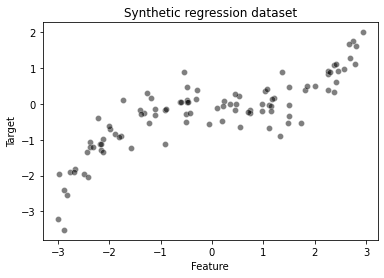

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# create a random number generator that will be used to set the randomness
rng = np.random.RandomState(1)

def generate_data(n_samples=30):
  """Generate synthetic dataset. 

  Parameters
  ----------
  n_samples: int, Default -> 30
    Number of data points to be sampled.

  Returns
  -------
  X_train
    Training features.

  X_test
    Testing data.
    
  y_train    
    Training target.
  """
  x_min, x_max = -3, 3
  x = rng.uniform(x_min, x_max, size=n_samples)
  noise = 4.0 * rng.randn(n_samples)
  y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
  y /= y.std()

  x_test = np.linspace(x_max, x_min, num=300)

  X_train = pd.DataFrame(x, columns=["Feature"])
  X_test = pd.DataFrame(
      x_test, columns=["Feature"])
  y_train = pd.Series(y, name="Target")

  return X_train, X_test, y_train

X_train, X_test, y_train = generate_data(n_samples=100)

# Plot the Dataset
sns.scatterplot(
    x=X_train["Feature"],
    y=y_train, 
    color="black",
    alpha=0.5
  )
_ = plt.title("Synthetic regression dataset")

### Exercise 1.1 (Bagging Implementation)

In this exercise, you have to implement Bagging from scratch (do not use sklearn class for bagging). Use [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) as a base learner (See also the following [description](https://en.wikipedia.org/wiki/Decision_tree_learning) of the concept) to train the training dataset (`X_train`, `y_train`) and predict on the testing dataset (`X_test`). Compare the results of the ensemble bagging with the individual base learners.

[3]


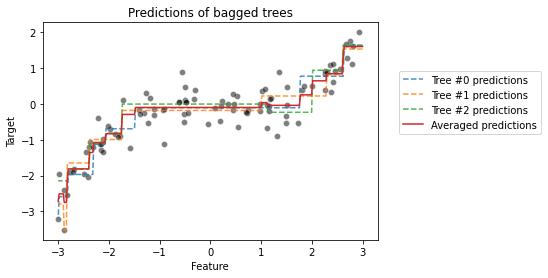

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
import numpy as np

def bootstrap_sample(X, y):
  """
  Resample the data with replacement from the dataset for bootstrapping.

  Parameters
  ----------
  X: pandas.DataFrame
    Feature dataframe for resampling.

  y: pandas.DataFrame
    Target dataframe for resampling.

  Returns
  -------
  X_bootstrap: pandas.DataFrame
    Resampled features dataframe with replacement.

  y_bootstrap: pandas.DataFrame
    Resampled target dataframe with replacement.
  """
  # Indices corresponding to a sampling with replacement of the same sample
  # size than the original X
  bootstrap_indices = rng.choice(
      np.arange(y.shape[0]), size=y.shape[0], replace=True,
  )
  # In pandas, we need to use `.iloc` to extract rows using an integer
  # position index:
  X_bootstrap = X.iloc[bootstrap_indices]
  y_bootstrap = y.iloc[bootstrap_indices]
  return X_bootstrap, y_bootstrap

def evaluate(n_bootstraps):
  bag_of_base_estimators = []
 
  for bootstrap_index in range(n_bootstraps):
    base_estimator = DecisionTreeRegressor(max_depth=3, random_state=0)

    # draw a bootstrap from the original data
    X_bootstrap, y_bootstrap = bootstrap_sample(
        X_train, y_train
    )
    base_estimator.fit(X_bootstrap, y_bootstrap)
    bag_of_base_estimators.append(base_estimator)

  # Aggregating the predictions from the base_estimators. In regression, the most 
  # straightforward way to combine those predictions is just to average them: 
  # for a given test data point, we feed the input feature values to each of the 
  # n trained models in the ensemble and as a result compute n predicted values 
  # for the target variable. The final prediction of the ensemble for the test 
  # data point is the average of those n values.
  sns.scatterplot(
      x=X_train["Feature"], 
      y=y_train, 
      color="black",
      alpha=0.5
  )
  
  bag_predictions = []
  for base_estimator_index, base_estimator in enumerate(bag_of_base_estimators):
    base_estimator_predictions = base_estimator.predict(X_test)

    # Plot the predictions of each base estimator
    plt.plot(
        X_test["Feature"], 
        base_estimator_predictions, 
        linestyle="--", 
        alpha=0.8,
        label=f"Tree #{base_estimator_index} predictions"
    )
    bag_predictions.append(base_estimator_predictions)


  bag_predictions = np.mean(bag_predictions, axis=0)

  # Plot the predictions of the Aggregated estimator
  plt.plot(
      X_test["Feature"], 
      bag_predictions, 
      label="Averaged predictions",
      linestyle="-"
  )
  plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
  _ = plt.title("Predictions of bagged trees")

range_list = [*range(3, 4)]
print(range_list)
for i in range_list:
  evaluate(i)


### Exercise 1.2 (Bagging using sklearn)

The aim of this exercise is to investigate if we can tune the hyperparameters of a bagging regressor and evaluate the gain obtained. 

- Use the [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from sklearn and split it into a training and a testing set.

- Create a [`BaggingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) and use a [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) as the `base_estimator`.

- Train the regressor and evaluate its generalization performance on the testing set using appropriate metrics.

- Tune the important parameters of the bagging regressor. *Hint*: You may find [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?highlight=randomizedsearchcv#sklearn.model_selection.RandomizedSearchCV) useful.

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


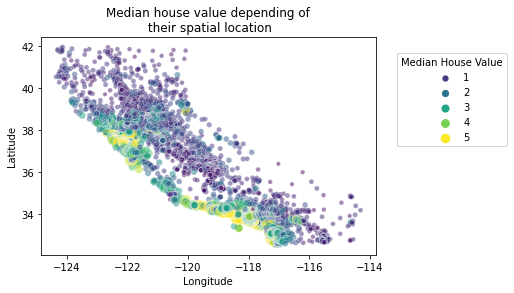

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# We will load the California housing dataset and split it into a training and
# a testing set.
X, y = fetch_california_housing(as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.5)

display(X.head())

# Plotting the Data
sns.scatterplot(data=X, x="Longitude", y="Latitude",
                size=y, hue=y,
                palette="viridis", alpha=0.5)
plt.legend(title="Median House Value", bbox_to_anchor=(1.05, 0.95),
           loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")
plt.show()

In [10]:
# Create a BaggingRegressor and provide a DecisionTreeRegressor
# to its parameter base_estimator. Train the regressor and evaluate its
# generalization performance on the testing set using the mean absolute error.
base_estimator = DecisionTreeRegressor()
bagging = BaggingRegressor(base_estimator=base_estimator, n_jobs=2)
bagging.fit(X_train, y_train)
y_predicted = bagging.predict(X_test)
print(f"Basic mean absolute error of the bagging regressor:\n"
      f"{mean_absolute_error(y_test, y_predicted):.2f}")

# Now, create a RandomizedSearchCV instance using the previous model and
# tune the important parameters of the bagging regressor. Find the best
# parameters  and check if you are able to find a set of parameters that
# improve the default regressor still using the mean absolute error as a
# metric.
param_grid = {
    "n_estimators": randint(10, 30),
    "max_samples": [0.5, 0.8, 1.0],
    "max_features": [0.5, 0.8, 1.0],
    "base_estimator__max_depth": randint(3, 10),
}
search = RandomizedSearchCV(
    estimator=bagging, 
    param_distributions=param_grid, 
    n_iter=20, 
    scoring="neg_mean_absolute_error", 
    verbose=1
)
_ = search.fit(X_train, y_train)

for k, v in search.best_params_.items():
  print("Best Parameters:\n{}: {}\n".format(k, v))

y_predicted = search.predict(X_test)
print(f"Mean absolute error after tuning of the bagging regressor:\n"
      f"{mean_absolute_error(y_test, y_predicted):.2f}")

# We see that the predictor provided by the bagging regressor does not need
# much hyperparameter tuning compared to a single decision tree.

Basic mean absolute error of the bagging regressor:
0.37
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:
base_estimator__max_depth: 9

Best Parameters:
max_features: 0.8

Best Parameters:
max_samples: 0.8

Best Parameters:
n_estimators: 23

Mean absolute error after tuning of the bagging regressor:
0.39


## Boosting

Boosting means combining several weak learners in series. Its main focus is to improve over the errors of the previous model. The key propoerty of boosting ensembles is the idea of **correcting prediction errors**. The models are fitted and added to the ensembles sequentially such that the second model attempts to correct the predictions of the first model, the third corrects the second model, and so on.

**Boosting Algorithms** combine each weak learner to create one strong prediction rule. To identify the weak rule, there is a base model. Whenever the model is applied, it creates new prediction rules using modified data. After a fixed number of iterations, it combines all weak rules to create one single prediction rule. There are two major algorithms in Boosting: [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), [Gradient Tree Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting), …

### Exercise 1.3 (Adaptive Boosting)

In this exercise, you will implement Adaptive Boostive (AdaBoost) algorithm. The aim is to gather intuition regarding the internal machinery of AdaBoost and boosting in general.

- Use the [penguins](https://allisonhorst.github.io/palmerpenguins/) dataset from `penguins_classification.csv` to predict the penguin *species* from the features *culmen length* and *culmen depth*.

- Create an [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) and use a [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) as the `base_estimator` and predict on the test dataset.

- Compare the classification generalization performance of each classifier used in training the `AdaBoostClassifier`

In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

# Creating features and labels dataframes.
penguins = pd.read_csv("penguins_classification.csv")
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

X, y = penguins[culmen_columns], penguins[target_column].map({'Adelie': 0, 'Gentoo': 1, 'Chinstrap': 2})

print(f'Shape X: {X.shape}')
print(f'Shape y: {y.shape}')

Shape X: (342, 2)
Shape y: (342,)


We will purposefully train a shallow decision tree. Since it is shallow, it is unlikely to overfit and some of the training examples will even be misclassified.

In [6]:
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier(max_depth=2, random_state=0)
_ = base_estimator.fit(X, y)
y_pred = base_estimator.predict(X)

We can predict on the same dataset and check which samples are misclassified.

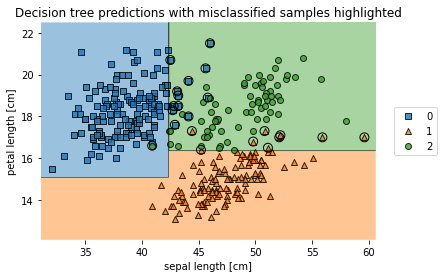

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

misclassified_samples_idx = np.flatnonzero(y != y_pred)
data_misclassified = X.iloc[misclassified_samples_idx]

# Plotting decision regions
plot_decision_regions(
    X.to_numpy(), 
    y.to_numpy().ravel(), 
    clf=base_estimator, 
    legend=2,
    X_highlight=data_misclassified.to_numpy()
)

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.title("Decision tree predictions with misclassified samples highlighted")
plt.show()

We observe that several samples have been misclassified by the classifier.

Boosting relies on creating a new classifier which tries to correct these misclassifications. In scikit-learn, learners have a parameter `sample_weight` which forces it to pay more attention to samples with higher weights during the training.

This parameter is set when calling `classifier.fit(X, y, sample_weight=weights)`. We will use this trick to create a new classifier by ‘discarding’ all correctly classified samples and only considering the misclassified samples. Thus, misclassified samples will be assigned a weight of 1 and well classified samples will be assigned a weight of 0.

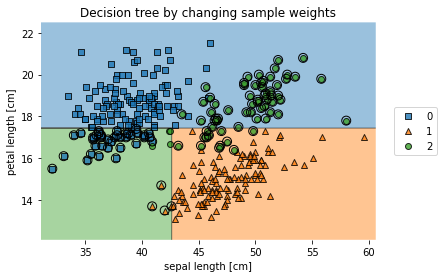

Number of samples previously misclassified and still misclassified: 0


In [8]:
sample_weight = np.zeros_like(y, dtype=int)
sample_weight[misclassified_samples_idx] = 1

base_estimator_new = DecisionTreeClassifier(max_depth=3, random_state=0)
base_estimator_new.fit(X, y, sample_weight=sample_weight.ravel())
y_pred_new = base_estimator_new.predict(X)

newly_misclassified_samples_idx = np.flatnonzero(y.to_numpy().ravel() != y_pred_new)
remaining_misclassified_samples_idx = np.intersect1d(
    misclassified_samples_idx, newly_misclassified_samples_idx
)

# Plotting decision regions
plot_decision_regions(X.to_numpy(), y.to_numpy().ravel(), clf=base_estimator_new, legend=2, 
                      X_highlight=X.iloc[newly_misclassified_samples_idx].to_numpy()
                      )

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.title("Decision tree by changing sample weights")
plt.show()

print(f"Number of samples previously misclassified and "
      f"still misclassified: {len(remaining_misclassified_samples_idx)}")

We see that the decision function drastically changed. Qualitatively, we see that the previously misclassified samples are now correctly classified.

However, we are making mistakes on previously well classified samples. Thus, we get the intuition that we should weight the predictions of each classifier differently, most probably by using the number of mistakes each classifier is making.

So we could use the classification error to combine both trees.

In [9]:
ensemble_weight = [
    (y.shape[0] - len(misclassified_samples_idx)) / y.shape[0],
    (y.shape[0] - len(newly_misclassified_samples_idx)) / y.shape[0],
]
ensemble_weight

[0.935672514619883, 0.6929824561403509]

The first classifier was 94% accurate and the second one 69% accurate. Therefore, when predicting a class, we should trust the first classifier slightly more than the second one. We could use these accuracy values to weight the predictions of each learner.

To summarize, boosting learns several classifiers, each of which will focus more or less on specific samples of the dataset. Boosting is thus different from bagging: here we never resample our dataset, we just assign different weights to the original dataset.

Boosting requires some strategy to combine the learners:

- one needs to define a way to compute the weights to be assigned to samples;

- one needs to assign a weight to each learner when making predictions.

Indeed, we defined a really simple scheme to assign sample weights and learner weights. However, there are statistical theories (like in AdaBoost) for how these sample and learner weights can be optimally calculated.

We will use the AdaBoost classifier implemented in scikit-learn and look at the underlying decision tree classifiers trained.

Error of each classifier: [0.05263158 0.05864198 0.08787269]
Weight of each classifier: [3.58351894 3.46901998 3.03303773]


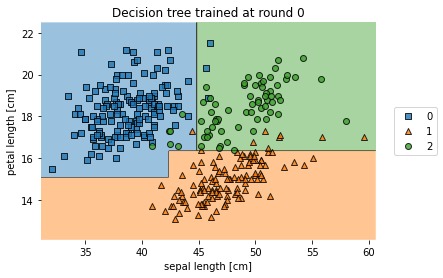

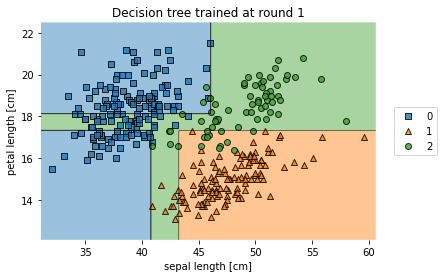

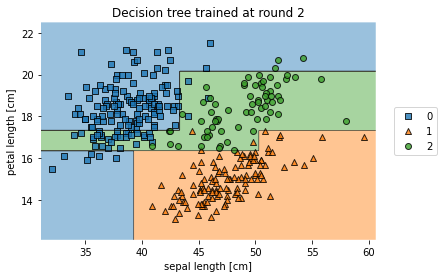

In [11]:
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier(max_depth=3, random_state=0)
adaboost = AdaBoostClassifier(base_estimator=base_estimator,
                              n_estimators=3, algorithm="SAMME",
                              random_state=0)
_ = adaboost.fit(X, y)

for boosting_round, base_estimator in enumerate(adaboost.estimators_):
    plt.figure()
    # we convert `X` into a NumPy array to avoid a warning raised in scikit-learn
    
    # Plotting decision regions
    plot_decision_regions(
        X.to_numpy(), 
        y.to_numpy().ravel(), 
        clf=base_estimator, 
        legend=2,
      )

    # Adding axes annotations
    plt.xlabel('sepal length [cm]')
    plt.ylabel('petal length [cm]')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    plt.title("Decision tree by changing sample weights")
    _ = plt.title(f"Decision tree trained at round {boosting_round}")

print(f"Error of each classifier: {adaboost.estimator_errors_}")
print(f"Weight of each classifier: {adaboost.estimator_weights_}")

We see that AdaBoost learned three different classifiers, each of which focuses on different samples. Looking at the weights of each learner, we see that the ensemble gives the highest weight to the first classifier. This indeed makes sense when we look at the errors of each classifier. The first classifier also has the highest classification generalization performance.

While AdaBoost is a nice algorithm to demonstrate the internal machinery of boosting algorithms, it is not the most efficient. 